Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Config

In [2]:
# Add your input path
labeled_path = "../data/labels.parquet"

Loading Dataset

In [3]:
dataset = pd.read_parquet(labeled_path)
dataset.head()

,Location,Date,Demand
0,1,2023-01-01,40.0
1,1,2023-01-02,31.0
2,1,2023-01-03,27.0
3,1,2023-01-04,7.0
4,1,2023-01-05,15.0


Evaluation

Generate temporary predicted Data

In [4]:
def generate_temporary_prediction(dataset):
    predicted_demand = dataset.Demand.shift(1)
    predicted_data = pd.DataFrame(dataset[['Location', 'Date']])
    predicted_data['Demand'] = predicted_demand
    return predicted_data


In [5]:
predicted_data = generate_temporary_prediction(dataset)
predicted_data = predicted_data.dropna()
predicted_data.head()

,Location,Date,Demand
1,1,2023-01-02,40.0
2,1,2023-01-03,31.0
3,1,2023-01-04,27.0
4,1,2023-01-05,7.0
5,1,2023-01-06,15.0


calculate loss functions

In [6]:
# fix_inf_val will add to numerator and denumerator to prevent having the inf value
def calculate_loss_mape(actual_data, predicted_data, fix_inf = 10):
    
    losses_df = actual_data[['Location','Date']].copy()
    losses_df['actual_demand'] = actual_data.Demand
    losses_df['predicted_demand'] = predicted_data.Demand
    losses_df = losses_df.dropna()

    fix_inf_val = np.where(losses_df['actual_demand']==0, fix_inf, losses_df['actual_demand'])
    
    losses_df['error'] = ((np.abs(losses_df['actual_demand']-losses_df['predicted_demand'])+fix_inf_val)/
                          (losses_df['actual_demand']+fix_inf_val))*100

    loss_per_location = losses_df.groupby('Location').agg({'error':'mean'})
    loss_per_date = losses_df.groupby('Date').agg({'error':'mean'})

    return loss_per_location, loss_per_date


In [7]:
loss_per_location, loss_per_date = calculate_loss_mape(dataset, predicted_data)
loss_per_location.head()

,error
Location,
1,78.647898
2,102.416667
3,94.972222
4,92.190355
5,108.388889


In [8]:
loss_per_date.head()

,error
Date,
2023-01-01,4204.487103
2023-01-02,114.527559
2023-01-03,78.399740
2023-01-04,80.877746
2023-01-05,77.009085


Plot accuracies function

In [9]:
def plot_acc(losses: pd.DataFrame, label):
    ax = losses.plot.bar(rot=0)
    plt.xlabel(str(label))
    plt.ylabel('Loss(mape)')
    title = 'Model Accuracy per '+ str(label)
    plt.title(title)
    plt.legend()
    plt.show()


Evaluate Model function

In [15]:
def prepare_report(loss: pd.DataFrame, plot_label):
    min_threshhold = loss['error'].min()
    max_threshhold = loss['error'].max()
    mean_threshhold = loss['error'].mean()

    report_dict = {
            'best_accuracy': min_threshhold,
            'best_accuracy_point': [loss['error'].idxmin()],
            'worst_accuracy': max_threshhold,
            'worst_accuracy_point': [loss['error'].idxmax()],
            'mean_accuracy': mean_threshhold
        }
    
    plot_acc(loss, plot_label)

    return report_dict

In [16]:
def evaluate_model(dataset, predicted_data):
    loss_per_location, loss_per_date = calculate_loss_mape(dataset, predicted_data)
    date_report_df = pd.DataFrame(prepare_report(loss_per_date, 'date'))
    loc_report_df = pd.DataFrame(prepare_report(loss_per_location, 'location'))
    return(date_report_df, loc_report_df)
    

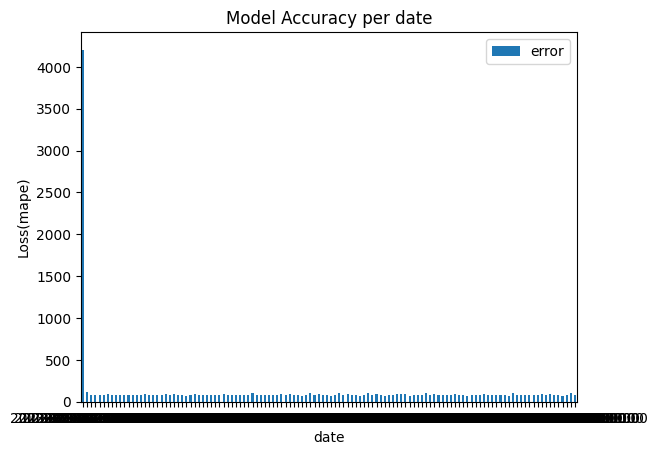

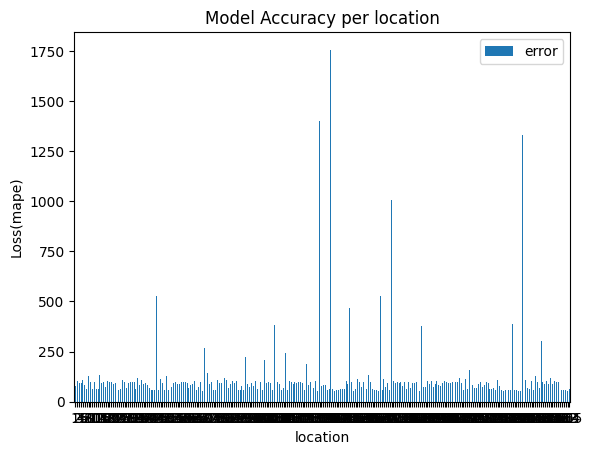

In [17]:
date_report_df, loc_report_df = evaluate_model(dataset, predicted_data)

In [21]:
print("date\n",date_report_df,"\nlocation\n", loc_report_df)

date
    best_accuracy best_accuracy_point  worst_accuracy worst_accuracy_point  \
0      70.686899          2023-04-27     4204.487103           2023-01-01   

   mean_accuracy  
0     116.532945   
location
    best_accuracy  best_accuracy_point  worst_accuracy  worst_accuracy_point  \
0      54.221274                  186     1755.629782                   139   

   mean_accuracy  
0     116.401716  
